In [1]:
import pandas as pd 
import os
import sys
import matplotlib as plt 
import seaborn as sns

In [3]:
event = pd.read_csv("google_analytics_event.csv")
pv = pd.read_csv("google_analytics_pageview.csv")
pv = pv.rename(columns={"total" : "pv_total"})

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3291: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 분석 방법론

* Step 1. Best Conversion Rate을 보이는 카드 유형 Top3를 찾아낸다
* Step 2. 해당 카드 유형은 왜 신청수가 높았는지 EDA를 통해 원인을 정의한다
* Step 3. 카드 신청 수를 높이기 위한 가설을 설정한다 => 내생적으로 전략을 만들 것인지, 외생적으로 전략을 만들 것인지 정의
* Step 4. 설정한 가설이 성공적으로 채택되기 위한 실험 Framework를 만든다

In [4]:
event.head()

,category,action,path,date,total,card_id,rank_in_list,card_name
0,카드:결과리스트,상품노출,/cards/ranking,2020-06-09,2,629515.0,4.0,사과카드
1,카드:결과리스트,상품노출,/cards/ranking,2020-06-09,24,629515.0,4.0,사과카드
2,카드:결과리스트,상품노출,/cards/ranking,2020-06-09,17,629515.0,4.0,사과카드
3,카드:결과리스트,상품노출,/cards/ranking,2020-04-27,5,629515.0,4.0,사과카드
4,카드:결과리스트,상품노출,/cards/ranking,2020-04-27,9,629515.0,4.0,사과카드


In [5]:
date = pd.DataFrame(event["date"].unique())
date.columns = ["date"]

date.sort_values("date")

# 2020년 3월말부터 6월말까지

,date
86,2020-03-29
56,2020-03-30
87,2020-03-31
61,2020-04-01
72,2020-04-02
...,...
83,2020-06-24
34,2020-06-25
49,2020-06-26
64,2020-06-27


In [6]:
pd.pivot_table(pv, index="path", values="pv_total").sort_values("path", ascending=False)

,pv_total
path,
cards/themes/후불-하이패스-카드-b7d0,29.711429
cards/themes/혜택이-너무-좋아-단종된-전설이-신용카드-top3-ulzRi,3.058252
cards/themes/현대카드-베스트-카드-cae8,2.000000
cards/themes/현금으로-돌려받는-캐시백-카드-BEST-msUBU,2.855072
cards/themes/해외직구족-신용카드-4kDGI,3.623894
...,...
/cards/100601,3.666667
/cards/100508,8.000000
/cards/10032,1.914286


In [7]:
event_by_cards = pd.pivot_table(event, index="action", columns="card_name", values ="total").transpose()

In [8]:
event_by_cards.sort_values("신청", ascending=False)

action,상품노출,신청
card_name,,
딸기카드,33.614563,2.973810
무화과카드,NaN,2.750000
사과카드,37.657874,2.457432
키위카드,NaN,2.313592
복숭아카드,87.344612,2.190834
바나나카드,NaN,2.177927
오렌지카드,162.610020,2.036216
살구카드,122.279084,1.884393
단감카드,NaN,1.861702


In [9]:
event_by_cards["노출 대비 신청"] = event_by_cards["신청"]/event_by_cards["상품노출"]

event_by_cards

action,상품노출,신청,노출 대비 신청
card_name,,,
단감카드,NaN,1.861702,NaN
딸기카드,33.614563,2.973810,0.088468
무화과카드,NaN,2.750000,NaN
바나나카드,NaN,2.177927,NaN
복숭아카드,87.344612,2.190834,0.025083
사과카드,37.657874,2.457432,0.065257
살구카드,122.279084,1.884393,0.015411
수박카드,7.908917,NaN,NaN
오렌지카드,162.610020,2.036216,0.012522


In [10]:
conversion_by_cards = event_by_cards.sort_values("노출 대비 신청", ascending=False)
conversion_by_cards[:5]

action,상품노출,신청,노출 대비 신청
card_name,,,
딸기카드,33.614563,2.973810,0.088468
사과카드,37.657874,2.457432,0.065257
복숭아카드,87.344612,2.190834,0.025083
살구카드,122.279084,1.884393,0.015411
자두카드,136.551526,1.806223,0.013227


In [11]:
peaches = event["card_name"] == "복숭아카드"

peaches = event.loc[peaches, :].set_index("date").sort_values("date")

In [12]:
pd.pivot_table(peaches, index="category", values="total").sort_values("total", ascending=False)

,total
category,
카드:카드랭킹,186.100227
카드:결과리스트,55.621187
카드:뱅크샐러드는매일연회비할인,8.844843
카드:히어로,2.597281
카드:온라인프로모션신청팝업,2.561609
카드:결과카드,2.149867
카드:카드,2.075353
카드:카드정보하단,1.880395
카드:고정_신청,1.596491


In [156]:
peaches_total = pd.pivot_table(peaches, index="path", values="total")[1:].sort_values("total", ascending=False)
peaches_total.head(10)

,total
path,
/cards/ranking,54.670512
/cards/questions,39.625943
/cards/themes/뱅크샐러드-2019-상반기-인기카드-TOP-5-Fafqa,19.200837
/cards/themes/2019-최고의-신용카드-YNs1z,18.990415
/cards/themes/2020년-신용카드-추천-ZzvJb,15.359375
/cards/promotion/annual-fee,12.797368
/cards/themes/PP카드가-무료로-제공되는-카드-4724,7.840164
/cards/322826,7.346626
/cards/724290,6.903911


In [14]:
date = peaches.index.unique()

In [122]:
# 복숭아카드 신청수 시각화 (총 91일)
from matplotlib import pyplot as plt
import datetime as dt

x = date
y = pd.pivot_table(peaches, index="date", values="total")
y_avrg = y.mean()

upper_bound = y_avrg+2*y.std()
lower_bound = y_avrg-2*y.std()

print(upper_bound)
print(lower_bound)

total    93.105012
dtype: float64
total    51.41955
dtype: float64


In [204]:
upper_outlier = y>upper_bound
lower_outlier = y<lower_bound

In [215]:
pd.pivot_table(peaches, index="path", values="total").sort_values("total", ascending=False)[:10]

,total
path,
/,811.813820
/cards/ranking,54.670512
/cards/questions,39.625943
/cards/themes/뱅크샐러드-2019-상반기-인기카드-TOP-5-Fafqa,19.200837
/cards/themes/2019-최고의-신용카드-YNs1z,18.990415
/cards/themes/2020년-신용카드-추천-ZzvJb,15.359375
/cards/promotion/annual-fee,12.797368
/cards/themes/PP카드가-무료로-제공되는-카드-4724,7.840164
/cards/322826,7.346626


In [199]:
y.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total,92.0,72.262281,10.421365,55.712941,63.609566,71.355822,79.284047,103.506579


In [146]:
upper_outlier.sum()

total    3
dtype: int64

In [145]:
lower_outlier.sum()

total    0
dtype: int64

<AxesSubplot:xlabel='date'>

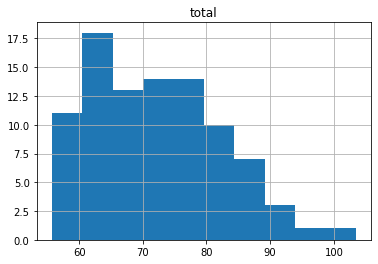

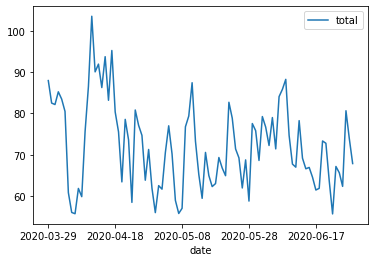

In [147]:
y.hist()
y.plot()

## 복숭아카드 내외부 요인과 신청수 간의 회귀분석 

In [163]:
apply = peaches["action"]=="신청"
recommend = peaches["action"]=="상품노출"

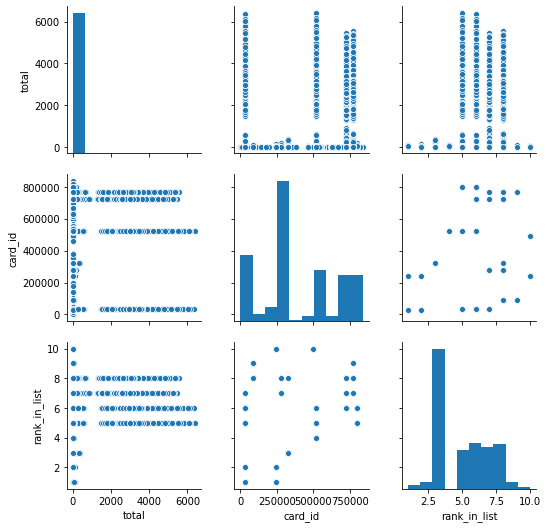

In [182]:
sns.pairplot(peaches)

In [198]:
pd.pivot_table(peaches, index="rank_in_list", values="total").sort_values("total", ascending=False)

,total
rank_in_list,
5.0,184.294380
6.0,158.462217
7.0,156.359015
8.0,145.636595
1.0,19.344660
2.0,16.764946
4.0,12.142857
9.0,10.692521
3.0,8.844843
